<a href="https://colab.research.google.com/github/Raahee1729/PyCBC-Tuts-and-Examples/blob/main/mass_Estimation_subtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mass estimate subtraction -

why we are doing this?

---->Because we generate a signal with masses m1 and m2 and some spin.
now, we get the data(signal+noise)
we subtract the estimates signal from the data, if the signal from data vanishes, there is only niose left in the data then our therotical/estimated signal is true.
1. read the data from teh given file
2. make back of time domain and freq domain data
3. take the PSD
4. take a series of chirp mass and get its component masses m1 and m1
5. creat waveform from  combination of m1 and m2 and run then to calculate the SNR
6. the hight SNR location is obtained in GPS time
7. get the q tranform spectrogram see the chip
8. subtract the estimated chirp signal from it, with most accurate masses



In [ ]:
# Install PyCBC and downgrade NumPy
!pip install -q numpy==1.23.5
!pip install -q pycbc

# Restart the runtime to finalize NumPy change
import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 88.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.8.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.1

This for reading the data

Calculating the PSD

In [1]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

--2025-07-07 07:20:27--  https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.133
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57824232 (55M)
Saving to: ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’

H-H1_LOSC_CLN_4_V1- 100%[===================>]  55.14M  34.6MB/s    in 1.6s    

2025-07-07 07:20:29 (34.6 MB/s) - ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ saved [57824232/57824232]

--2025-07-07 07:20:30--  https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.133
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62070438 (59M)
Saving to: ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’

L-L1_LOSC_CLN_4_V1- 100%[===================>]  59.19M  36.0MB/s    in 1.6s    

20

In [1]:
%matplotlib inline
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame

merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),                # syntax to write a fiel name
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,                #start 224 sec before the merger
                   end_time=merger.time + 32,                   # stop at 32 sec after merger
                   check_integrity=False)

    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)          # Crops 4 seconds off the start and end of the filtered strain time series.

    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

/usr/local/lib/python3.11/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Calculate the PSD

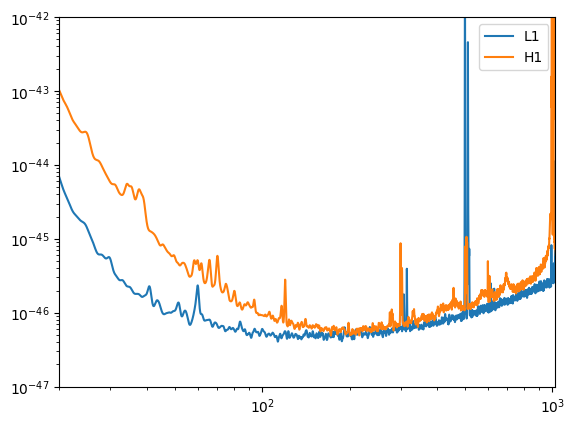

In [3]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psds = {}
for ifo in ['L1', 'H1']:
    # Calculate a psd from the data. We'll use 2s segments in a median - welch style estimate
    # We then interpolate the PSD to the desired frequency step.
    psds[ifo] = interpolate(strain[ifo].psd(2), stilde[ifo].delta_f)          #( estimates the PSD with segments of 2 sec, )

    # We explicitly control how much data will be corrupted by overwhitening the data later on
    # In this case we choose 2 seconds.
    # we have to whiten the PSD, for that we take square root of it devide it, if the inverse of PSD is not smooth then its not good
    # so to make it smooth we do this follwing command,

# Step 1:
# Take the inverse square root of the PSD → this is your whitening filter in frequency domain:

# Step 2:
# Convert this filter into the time domain → now it’s a long, complex filter
# But long filters can cause ringing and wraparound effects.

# Step 3:
# You truncate this time-domain whitening filter to a fixed duration (say 2 seconds), then apply a window (like the Hann window) to taper the edges.
# This ensures the filter is:
# Short enough to not affect distant parts of the signal
# Smooth enough to avoid sharp discontinuities

#Step 4:
#Convert it back to frequency domain — the result is a smoothed, safe version of your whitening filter.

# we do so the ringing(ripples) does not appear

psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 * strain[ifo].sample_rate),
                                    low_frequency_cutoff=15.0,
                                    trunc_method='hann')

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
    pylab.legend()

To estimate the best-fit component mass for the binary neutron star system (e.g. GW170817)
by trying different values and seeing which one gives the highest matched filter SNR across detectors.

In [4]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

# We will try different component masses and see which gives us the largest
# what is chirp mass M, its special combination of m1 and m2 it tell me how the spiral process is going on
chirp_mass = numpy.arange(1.1966, 1.1996, .0001) # creats an array srating from 1.1966 and ends at 1.1996 with step size 0.0001
masses = mass1_from_mchirp_q(chirp_mass, 1) # converts chip mass into componet masses


# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []

for m in masses:
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                             mass1=m, mass2=m,
                             f_lower=20, delta_f=stilde[ifo].delta_f)
    hp.resize(len(stilde[ifo]))

    # Matched filter the data and find the peak
    max_snr, max_time = {}, {}
    for ifo in ['L1', 'H1']:
        snr = matched_filter(hp, stilde[ifo], psd=psds[ifo], low_frequency_cutoff=20.0)

        # The complex SNR at the peak
        snr = snr.time_slice(merger.time - 1, merger.time + 1)        #extract 2 sec windown
        _, idx = snr.abs_max_loc() # finds the location of the highest SNR
        max_snr[ifo] = snr[idx]

        # The time of the peak
        max_time[ifo] = float(idx) / snr.sample_rate + snr.start_time

    network_snr = (abs(numpy.array(list(max_snr.values()))) ** 2.0).sum() ** 0.5
    snrs.append(max_snr)

    # Keep track of only the loudest peak
    if network_snr > nsnr:
        tmax, hmax, mmax, smax = max_time, hp, m, max_snr
        nsnr = network_snr

# See the SNR as a function of the component mass. Notice where this peaks as it gives us
# an estimate of what the parameters of the source system are. Note that masses
# here are in the *detector* frame, so if the source is located far away, it will in
# fact correspond to a lighter system due to cosmological redshift.
print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mmax)

We found the best Mass1=Mass2 was 1.38 solar masses (detector frame)


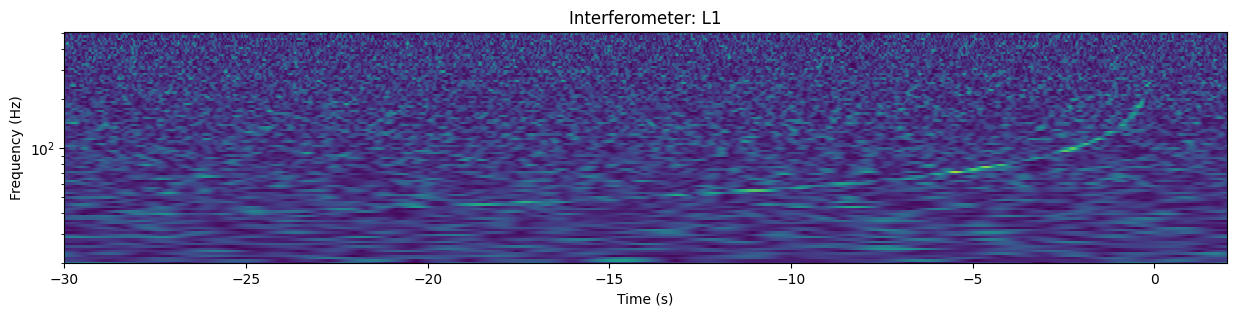

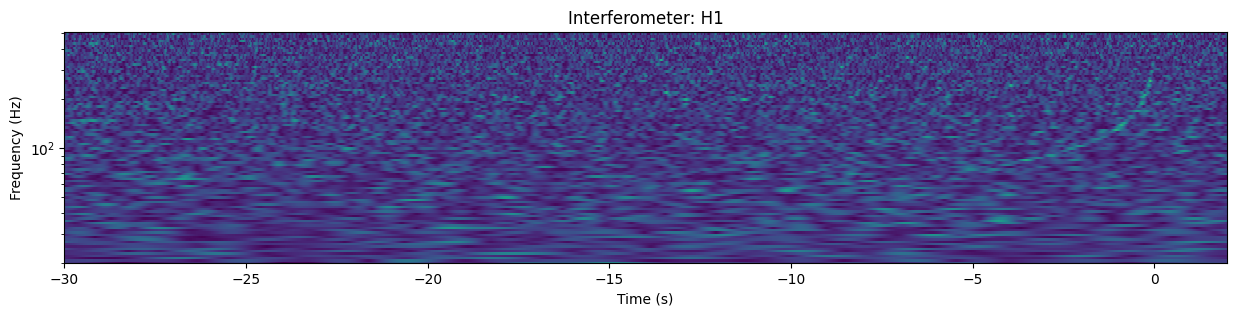

In [5]:
for ifo in ['L1', 'H1']:
    # Whiten the data
    hoft = (stilde[ifo] / psds[ifo] ** 0.5).to_timeseries()

    # Select the time around the event
    zoom = hoft.time_slice(merger.time - 30, merger.time + 2)

    # Calculate the qtransform (a kind of time-frequency representation similar to a spectrogram)
    times, freqs, power = zoom.qtransform(.01, logfsteps=100, frange=(20, 512), qrange=(110, 110))

    pylab.figure(figsize=(15,3))
    pylab.pcolormesh(times - merger.time, freqs, power**0.5, vmin=0, vmax=6)
    pylab.ylim(20, 512)
    pylab.title('Interferometer: %s' % ifo)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.yscale('log')

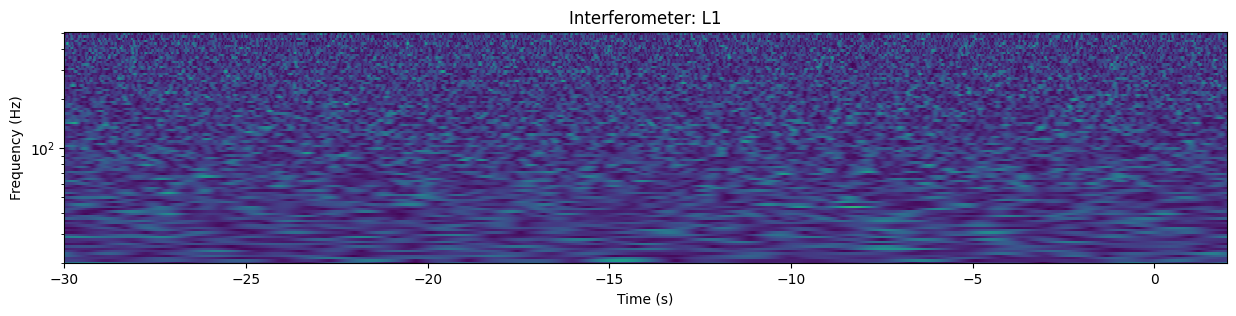

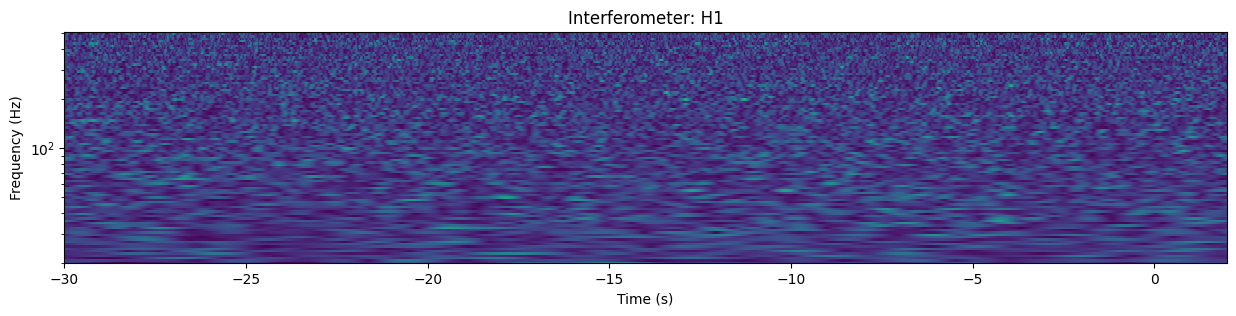

In [6]:
from pycbc.filter import sigma

for ifo in ['L1', 'H1']:
    # Shift the template to the maximum time at this sample rate
    dt =  tmax[ifo] - stilde[ifo].start_time
    inj = hmax.cyclic_time_shift(dt)

    # Scale the template to the SNR and phase we measured above
    inj /= sigma(hmax, psd=psds[ifo], low_frequency_cutoff=20.0) # This scales the template to unit SNR
    inj *= smax[ifo] # This scales the template to the SNR / phase we found

    # Subtract from the data
    stilde2 = stilde[ifo] - inj

    # Whiten the data
    hoft = (stilde2 / psds[ifo] ** 0.5).to_timeseries()

    # Select the time around the event
    zoom = hoft.time_slice(merger.time - 30, merger.time + 2)

    # Calculate the qtransform (a kind of time-frequency representation similar to a spectrogram)
    times, freqs, power = zoom.qtransform(.01, logfsteps=100, frange=(20, 512), qrange=(110, 110))

    pylab.figure(figsize=(15,3))
    pylab.pcolormesh(times - merger.time, freqs, power**0.5, vmin=0, vmax=6)
    pylab.ylim(20, 512)
    pylab.title('Interferometer: %s' % ifo)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.yscale('log')

# Note that a better match to the data can be found if you allow more
# freedom in the possible source parameters than we
# have here.